
#Assignment Set 2

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [ ]:
#@title Downloading The Data
import urllib.request
import os
import ast 
import idx2numpy
import glob 

print('Downloading cifar...')

urls = ['https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
        'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz']
for item in urls:
    urllib.request.urlretrieve(item, 'data/cifar/'+item.split('/')[-1])

!gunzip data/cifar/*.gz
!ls data/cifar/*

In [ ]:
#@title Manual Data Injection
from six.moves import cPickle as pickle
import platform
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
 
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
 
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
 
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
 
    x_train = X_train.astype('float32')
    x_val = X_val.astype('float32')
    x_test = X_test.astype('float32')
 
    x_train /= 255
    x_val /= 255
    x_test /= 255
    return x_train, y_train, x_val, y_val, x_test, y_test
 
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
 
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [ ]:
#@title Single Hidden Layer NNs **Without** Output One-Hot Encoding
#@markdown by using sparse categorical cross entropy there is no need to one-hot encode the true lables and from_logits set to true thus the model doesnt have any normalization layer.
epochs =  20#@param {type:"integer"}
verbose =  2#@param {type:"number"}
 
mdl_pool = {}
 
name = 'clf_flatten'
input = keras.Input(shape=(3072,))
x = layers.Dense(512, activation="relu")(input)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation="relu")(x)
output = layers.Dense(10)(x)
model = keras.Model(inputs=input, outputs=output, name=name)
 
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='Adam',
                metrics=['accuracy'])
mdl_pool[name] = {'params':model.count_params(),
                    'nolayers':2}
if(verbose):
    model.summary()
mdl_pool[name]['history'] = model.fit(x = x_train, y = y_train,
                    batch_size=128, epochs=epochs,
                    verbose=verbose,validation_data=(x_val,y_val),
                    validation_batch_size = 64).history

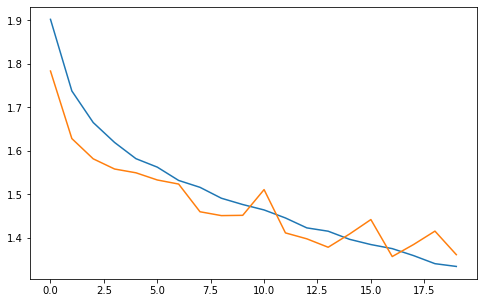

In [ ]:
#@title Plotting Training History
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [ ]:
#@title Performance Analysis
#@markdown After training different architectures, I failed to achieve more than 50% accuracy using flattened input
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.4013 - accuracy: 0.5050


[1.4013090133666992, 0.5049999952316284]

In [57]:
#@title Multi Hidden Layer CNNs **Without** Output One-Hot Encoding
#@markdown Training a convolutional neural network to compare the performance
name = 'conv_clf_1'
 
input = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation="relu")(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32,3,activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32,3,activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(128,activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10,'softmax')(x)
model = keras.Model(inputs=input, outputs=output, name=name)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer='Adam',
            metrics=['accuracy'])
model.summary()

Model: "conv_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 32)        1

In [ ]:
epochs =  100#@param {type:"integer"}
verbose =  2#@param {type:"number"}
model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 32)

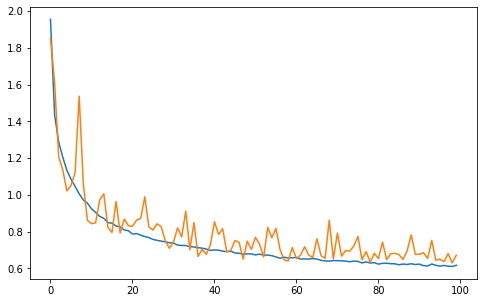

In [59]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [60]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.7784


[0.6828324794769287, 0.7784000039100647]